In [1]:
import numpy as np
from helpers import *
from implementations import *
from preprocess import *
from cross_validation import *

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
variables_set = {'PAQ650', '_RACEGR3', 'DRNK3GE5', '_FRTRESP', 'CHILDREN', 'VEGETAB1', 'PAQ670', '_SMOKER3', 
 '_RFBMI5', 'TOLDHI2', '_RFHLTH', '_PAINDX2', 'INCOME2', '_HISPANC', 'FVBEANS', '_DRNKWEK', 
 'PA1MIN_', 'FRUIT1', '_HCVU651', '_AGE80', 'HTM4', '_CHOLCHK', 'FVGREEN', 'VEGEDA1_', 'ALCDAY5', 
 '_RFPAVIG', '_RFSMOK3', '_RACE_G1', 'BEANDAY_', '_CASTHM1', 'ORNGDAY_', 'SMOKDAY2', '_CHLDCNT', 
 '_METVL11', 'PAQ665', '_AGEG5YR', 'MRACORG1', 'ORACE3', 'SEX', 'HAVARTH3', 'HISPANC3', '_PAQ6C', 
 'DROCDY3_', 'AGE', 'HLTHPLN1', '_MICHD', 'FTJUDA1_', '_VEGRESP', '_RFDRHV5', 'FRUTDA1_', '_VEGESUM', 
 'WEIGHT2', '_MISFRTN', 'CVDCRHD4', 'BPHIGH4', '_DRDXAR1', 'XPA1MIN_', '_PASTRNG', '_RACEG21', '_IMPAGE', 
 '_PRACE1', '_INCOMG', 'AVEDRNK', '_METVL21', '_MISVEGN', '_RFCHOL', 'PAQ655', 'HEIGHT3', '_PAREC1', 
 '_RFBING5', '_PACAT1', '_FRUTVEG', '_RFHYPE5', 'DRNKANY5', '_MRACE1', 'GRENDAY_', 'PAQ660', 'GENHLTH', 
 '_BMI5', 'FVORANG', '_EDUCAG', '_BMI5CAT', '_LTASTH1', 'MRACE1', '_ASTHMS1', '_FRUTSUM', 'ASTHMA3', 
 'BLOODCHO', 'SMOKE100', '_AGE_G', 'EDUCA', 'WTKG3', 'ASTHNOW', 'CVDINFR4', 'HTIN4', '_RACE', 'FRUITJU1', 
 'MRACASC1', '_AGE65YR', 'CHOLCHK'}


In [3]:
data_path="../data/dataset_to_release"
x_train, x_test, y_train, train_ids, test_ids, col_names_train, col_names_test,final_columns = load_csv_data(data_path, selected_cols=variables_set)

In [5]:
#Shifting -1 labels to 0
y_train[y_train==-1]=0

In [6]:
X_train,X_test,numerical_columns_indices=apply_preprocessing(x_train,x_test)

In [7]:
def undersample(X,y,seed=42):
    np.random.seed(seed)

    minority_count=y[y==1].shape[0]
    
    undersampled_majority_indices = np.random.choice(np.where(y == 0)[0], minority_count, replace=False)
    undersampled_indices = np.random.permutation(np.concatenate([undersampled_majority_indices, np.where(y == 1)[0]]))

    X_undersampled = X[undersampled_indices]
    y_undersampled = y[undersampled_indices]

    return X_undersampled,y_undersampled


In [8]:
def calculate_metrics(y_pred,y_true):
    accuracy=y_pred[y_pred==y_true].shape[0]/y_pred.shape[0]
    precision={};recall={}
    for label in np.unique(y_true):
        try:
            precision[label]=y_pred[(y_pred==label) & (y_true==label)].shape[0]/y_pred[y_pred==label].shape[0]
        except:
            continue
        try:
            recall[label]=y_pred[(y_pred==label) & (y_true==label)].shape[0]/y_true[y_true==label].shape[0]
        except:
            continue
    
    f1_scores = {}
    for label in precision.keys():
        if precision[label] + recall[label] != 0:
            f1_scores[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
        else:
            f1_scores[label] = 0.0

    return accuracy,precision,recall,f1_scores

def calculate_confusion_mat(y_pred,y_true):
    unique_labels=np.unique(y_true)
    conf_matrix=np.zeros((len(unique_labels),len(unique_labels)))
    #print(conf_matrix.shape)
    for i,pred_label in enumerate(unique_labels):
        for j,true_label in enumerate(unique_labels):
            conf_matrix[i,j]=y_pred[(y_pred==pred_label) & (y_true==true_label)].shape[0]
    return conf_matrix



In [9]:
k_folds=stratified_K_fold(y_train,seed=42)

In [11]:
def cross_validate(X_train,y_train,k_folds,train_func,loss_function,predict_function,*args,**kwargs):
    results=[]
    for i,(train_fold,val_fold) in enumerate(k_folds):
        results_dict={}
        #print("Fold",i+1)
        x_train_fold, x_val_fold = (X_train[train_fold],X_train[val_fold])
        y_train_fold=y_train[train_fold]
        y_val_fold=y_train[val_fold]
        
        x_train_fold,mean,std=standardize(x_train_fold)
        x_val_fold,_,_=standardize(x_val_fold,mean,std)

        
        initial_w=np.zeros((x_train_fold.shape[1],))

        X_undersampled,y_undersampled=undersample(X_train,y_train)

        try:
            w,loss=train_func(y_undersampled,X_undersampled,initial_w=initial_w,*args,**kwargs)
        except:
            w,loss=train_func(y_undersampled,X_undersampled,*args,**kwargs)
        y_pred,scores = predict_function(X_undersampled,w,threshold=0.5)
        tr_accuracy,tr_precision,tr_recall,tr_f1_scores=calculate_metrics(y_undersampled,y_pred)
        
        y_pred,scores = predict_function(x_val_fold,w,threshold=0.5)
        vl_accuracy,vl_precision,vl_recall,vl_f1_scores=calculate_metrics(y_val_fold,y_pred)


        results_dict["name"]=train_func.__name__
        results_dict["w"]=w
        results_dict["fold"]=i+1
        results_dict["tr_loss"]=loss
        results_dict["tr_accuracy"]=tr_accuracy
        results_dict["tr_precision"]=tr_precision
        results_dict["tr_recall"]=tr_recall
        results_dict["tr_f1_scores"]=tr_f1_scores

        results_dict["vl_loss"]=loss_function(y_val_fold,x_val_fold,w)
        results_dict["vl_accuracy"]=vl_accuracy
        results_dict["vl_precision"]=vl_precision
        results_dict["vl_recall"]=vl_recall
        results_dict["vl_f1_scores"]=vl_f1_scores
        
        
        results_dict["conf_matrix"]=calculate_confusion_mat(y_pred,y_val_fold)

        results.append(results_dict)
    
    return results

In [34]:
ridge_results=cross_validate(X_train,y_train,k_folds,
                             ridge_regression_gd,
                             calculate_mse_loss,
                             ridge_predict,
                            lambda_=0.01,
                            max_iters=100, 
                            gamma=0.001)


0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100


/Users/berkeargin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/berkeargin/Documents/GitHub/Turco-ML/project1/berke_trial/implementations.py:18: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_pred) ** 2) / 2


0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01
100
0.001
0.01

In [35]:
print(ridge_results[3]["tr_f1_scores"])
print(ridge_results[3]["vl_f1_scores"])

{0.0: 0.6666666666666666}
{0.0: 0.9538096111080113}


In [81]:
from itertools import product

functions=[
(ridge_regression_gd,calculate_mse_loss,ridge_predict),
(ridge_regression_gd,calculate_mse_loss,logit_predict),
(reg_logistic_regression,calculate_logistic_loss,logit_predict),
(least_squares,calculate_mse_loss,least_sq_predict),
(logistic_regression,calculate_logistic_loss,logit_predict),
(ridge_regression,calculate_mse_loss,ridge_predict),
(ridge_regression,calculate_mse_loss,logit_predict),
(mean_squared_error_sgd,calculate_mse_loss,least_sq_predict),
(mean_squared_error_gd,calculate_mse_loss,least_sq_predict)
]

grid_search_dict={
    "lambda_" : [1,0.5,0.1,0.01],
    "gamma" : [0.01,0.001,0.0001],
    "max_iters" : [100,250,500]
}

function_kwargs= {
"ridge_regression_gd" : ["lambda_","gamma","max_iters"],
"reg_logistic_regression" : ["lambda_","gamma","max_iters"],
"logistic_regression" : ["gamma","max_iters"],
"ridge_regression" : ["lambda_","max_iters"],
"least_squares" : [],
"mean_squared_error_sgd" : ["gamma","max_iters"],
"mean_squared_error_gd" : ["gamma","max_iters"] 
}

for function in functions:
    print(function)
    hyperparameters = function_kwargs[function[0].__name__]
    param_combinations = product(*[grid_search_dict[param] for param in hyperparameters])
    print(*param_combinations)
    for param in param_combinations:
        results=cross_validate(*function,*param)
        break
    break

    






(<function ridge_regression_gd at 0x7fab41c05d30>, <function calculate_mse_loss at 0x7facd0a2aee0>, <function ridge_predict at 0x7fab41c05c10>)
(1, 0.01, 100) (1, 0.01, 250) (1, 0.01, 500) (1, 0.001, 100) (1, 0.001, 250) (1, 0.001, 500) (1, 0.0001, 100) (1, 0.0001, 250) (1, 0.0001, 500) (0.5, 0.01, 100) (0.5, 0.01, 250) (0.5, 0.01, 500) (0.5, 0.001, 100) (0.5, 0.001, 250) (0.5, 0.001, 500) (0.5, 0.0001, 100) (0.5, 0.0001, 250) (0.5, 0.0001, 500) (0.1, 0.01, 100) (0.1, 0.01, 250) (0.1, 0.01, 500) (0.1, 0.001, 100) (0.1, 0.001, 250) (0.1, 0.001, 500) (0.1, 0.0001, 100) (0.1, 0.0001, 250) (0.1, 0.0001, 500) (0.01, 0.01, 100) (0.01, 0.01, 250) (0.01, 0.01, 500) (0.01, 0.001, 100) (0.01, 0.001, 250) (0.01, 0.001, 500) (0.01, 0.0001, 100) (0.01, 0.0001, 250) (0.01, 0.0001, 500)


In [80]:
results

[]

{'name': 'reg_ridge_regression',
 'fold': 2,
 'tr_loss': 0.1308487089972607,
 'tr_accuracy': 0.6935289042277826,
 'tr_precision': {0.0: 0.9141932700603969, 1.0: 0.47286453839516823},
 'tr_recall': {0.0: 0.6342711762945226, 1.0: 0.8464092664092664},
 'tr_f1_scores': {0.0: 0.7489309065205867, 1.0: 0.6067533905341821},
 'vl_loss': 0.6726567619167677,
 'vl_accuracy': 0.8725067426516525,
 'vl_precision': {0.0: 0.9113350715336275, 1.0: 0.4716134598792062},
 'vl_recall': {0.0: 0.9468301238083662, 1.0: 0.34000995272455836},
 'vl_f1_scores': {0.0: 0.9287435807904888, 1.0: 0.3951420516157016},
 'conf_matrix': array([[54527.,  3062.],
        [ 5305.,  2733.]])}

<AxesSubplot:>

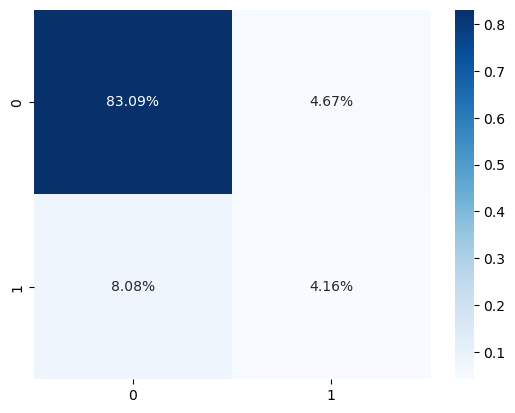

In [48]:
display(ridge_results[1])
cf_matrix=ridge_results[1]["conf_matrix"]
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

Fold 1
(173,)
0.540228070346257
Train loss: 0.5402280703229035
0.10474485995338291 0.9648632784500536
Train --- Accuracy: 0.7404659188955997 Precision: {0.0: 0.5544003451251078, 1.0: 0.9265314926660915} Recall: {0.0: 0.8829874948467775, 1.0: 0.675249952839087} F1: {0.0: 0.6811363756824085, 1.0: 0.7811806641690612}
Val   --- Accuracy: 0.5875020951742423 Precision: {0.0: 0.5544691803717074, 1.0: 0.9285591026747196} Recall: {0.0: 0.9876745363065289, 1.0: 0.16795680129845808} F1: {0.0: 0.7102257522398604, 1.0: 0.2844606560410224}
##########################################


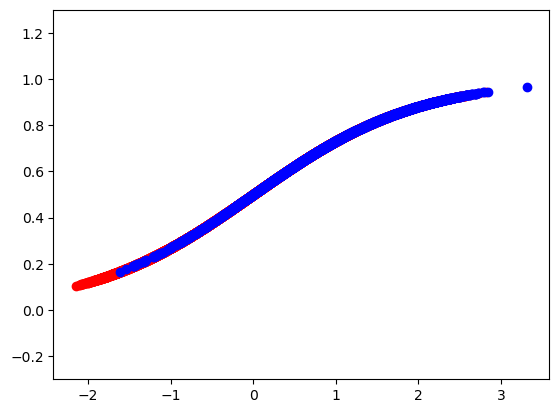

In [26]:
for i,(train_fold,val_fold) in enumerate(k_folds):
    print("Fold",i+1)
    x_train_fold, x_val_fold = (x_train[train_fold],x_train[val_fold])
    y_train_fold=y_train[train_fold];y_val_fold=y_train[val_fold]
    
    x_train_fold,mean,std=standardize(x_train_fold)
    x_val_fold,_,_=standardize(x_val_fold,mean,std)
    
    minority_index=y_train_fold[y_train_fold==1]
    majority_index=y_train_fold[y_train_fold==0]

    minority_count=y_train_fold[y_train_fold==1].shape[0]

    undersampled_majority_indices = np.random.choice(np.where(y_train_fold == 0)[0], minority_count, replace=False)
    undersampled_indices = np.concatenate([undersampled_majority_indices, np.where(y_train_fold == 1)[0]])

    X_undersampled = x_train_fold[undersampled_indices]
    y_undersampled = y_train_fold[undersampled_indices]


    initial_w=np.zeros((x_train_fold.shape[1],))

    w,loss=reg_logistic_regression(y_undersampled,X_undersampled,
                                                        lambda_=0.1,
                                                        initial_w=initial_w, 
                                                        max_iters=1000, 
                                                        gamma=0.06,
                                                        )#)class_weights=class_weights)
    print("Train loss:",loss)
    
    y_pred,scores = logit_predict(X_undersampled,w,threshold=0.5)
    tr_accuracy,tr_precision,tr_recall,tr_f1_scores=calculate_metrics(y_undersampled,y_pred)
    
    y_pred,scores = logit_predict(x_val_fold,w,threshold=0.5)
    vl_accuracy,vl_precision,vl_recall,vl_f1_scores=calculate_metrics(y_val_fold,y_pred)

    l0=(y_val_fold==0)
    l1=(y_val_fold==1)

    plt.scatter(x_val_fold.dot(w)[l0],scores[l0],c="r")
    plt.scatter(x_val_fold.dot(w)[l1],scores[l1],c="b")
    plt.ylim(-0.3,1.3)

    print(np.min(scores),np.max(scores))

    print("Train --- Accuracy:",tr_accuracy,"Precision:",tr_precision,"Recall:",tr_recall, "F1:",tr_f1_scores)
    print("Val   --- Accuracy:",vl_accuracy,"Precision:",vl_precision,"Recall:",vl_recall, "F1:",vl_f1_scores)
    print("##########################################")
    break


In [113]:
no_weight_scores=np.copy(scores)

In [ ]:

def grid_search_hyperparameters_weighted(y, x, k_indices):
    """Perform grid search with progress tracking."""
    gammas = [0.001, 0.01, 0.1]
    lambdas = [0.001, 0.01, 0.1, 1, 10]
    max_iters_values = [100, 500]
    model_funcs = []
    
    best_accuracy = 0
    best_f1 = 0
    best_hyperparameters = None
    
    total_models = len(model_funcs)
    for idx, model_func in enumerate(model_funcs):
        print(f"Evaluating Model {idx+1}/{total_models}: {model_func.__name__}")
        for gamma in gammas:
            for lambda_ in lambdas:
                for max_iters in max_iters_values:
                    print(f"Using hyperparameters: gamma={gamma}, lambda={lambda_}, max_iters={max_iters}")
                    avg_accuracy = 0
                    avg_f1 = 0
                    for k in range(len(k_indices)):
                        print(f"Processing Fold {k+1}/{len(k_indices)}")
                        train_x, train_y, test_x, test_y = prepare_data_for_fold(y, x, k_indices, k)
                        weights = None
                        if "weighted" in model_func.__name__:
                            class_weights = calculate_class_weights(train_y)
                            weights = np.array([class_weights[label] for label in train_y])
                        _, _, _, acc_test, precision_train, recall_train, precision_test, recall_test = train_and_evaluate(
                            train_x, train_y, test_x, test_y, model_func, weights, lambda_=lambda_, max_iters=max_iters, gamma=gamma)
                        avg_accuracy += acc_test
                        f1 = calculate_f1_score(precision_test, recall_test)
                        avg_f1 += np.mean(list(f1.values()))
                    avg_accuracy /= len(k_indices)
                    avg_f1 /= len(k_indices)
                    print("avg f1:", avg_f1)
                    if avg_accuracy > best_accuracy and avg_f1 > best_f1:
                        best_accuracy = avg_accuracy
                        best_f1 = avg_f1
                        best_hyperparameters = {"model_func": model_func, "gamma": gamma, "lambda": lambda_, "max_iters": max_iters}
                        
    return best_hyperparameters, best_accuracy, best_f1

In [26]:
y_train=(y_train+1)/2

In [139]:
def stratified_K_fold(y,k=5,seed=42):
    np.random.seed(seed)
    no_of_test_labels=np.floor(y.shape[0]/k)
    
    unique_labels=np.unique(y)
    label_ratio={};label_indexes={};label_count_p_fold={}

    picked_count=0
    for i,label in enumerate(unique_labels):
        label_ratio[label]=y[y==label].shape[0]/y.shape[0]
        label_indexes[label]=np.random.permutation(np.argwhere(y==label))
        if i<len(unique_labels)-1:
            label_count_p_fold[label]=np.floor(no_of_test_labels*label_ratio[label])
            picked_count+=label_count_p_fold[label]
        else:
            label_count_p_fold[label]=no_of_test_labels-picked_count

    folds=[]
    for i in range(k):
        index_arrs=[]
        for label in unique_labels:
            label_to_take=int(label_count_p_fold[label])
            index_arrs.append(label_indexes[label][i*label_to_take:(i+1)*label_to_take].flatten())
    
        test_fold=np.random.permutation(np.concatenate(index_arrs))
        train_fold=np.random.permutation(np.setdiff1d(np.indices(y.shape),test_fold,assume_unique=True))
        folds.append((train_fold,test_fold))
    
    return folds

def calculate_metrics(y_pred,y_true):
    accuracy=y_pred[y_pred==y_true].shape[0]/y_pred.shape[0]
    precision={};recall={}
    for label in np.unique(y_true):
        try:
            precision[label]=y_pred[(y_pred==label) & (y_true==label)].shape[0]/y_pred[y_pred==label].shape[0]
        except:
            continue
        try:
            recall[label]=y_pred[(y_pred==label) & (y_true==label)].shape[0]/y_true[y_true==label].shape[0]
        except:
            continue
    return accuracy,precision,recall

def calculate_confusion_mat(y_pred,y_true):
    unique_labels=np.unique(y_true)
    conf_matrix=np.zeros(len(unique_labels))
    for i,pred_label in enumerate(unique_labels):
        for j,true_label in enumerate(unique_labels):
            conf_matrix[i,j]=y_pred[y_pred==pred_label & y_true==true_label].shape[0]
    return conf_matrix

def cross_validate(fit_function,loss_function,folds):
    for i,(train_fold,val_fold) in enumerate(folds):
        print("Fold",i+1)
        x_train_fold=x_train_p[train_fold]
        x_val_fold=x_train_p[val_fold]
        
        y_train_fold=y_train[train_fold]
        y_val_fold=y_train[val_fold]

        initial_w=np.zeros((x_train_fold.shape[1],))

        x_train_norm,mean,std=standardize(x_train_fold)
        x_val_norm,_,_=standardize(x_val_fold,mean,std)

        w_0=x_train_norm.shape[0]/(2*y_train_fold[y_train_fold==0].shape[0])
        w_1=x_train_norm.shape[0]/(2*y_train_fold[y_train_fold==1].shape[0])

        w_0=1
        w_1=1

        print(w_0,w_1)
        threshold=(1/3)
        w,loss=fit_function(y_train_fold,x_train_norm,lambda_=0.3 ,initial_w=initial_w, max_iters=100, gamma=0.04,class_weights=(w_0,w_1))
        print("Train loss:",loss)

        y_pred = sigmoid(x_train_norm.dot(w))
        y_pred[y_pred>threshold]=1;y_pred[y_pred<=threshold]=0
        
        accuracy,precision,recall=calculate_metrics(y_train_fold,y_pred)

        print("Train --- Accuracy:",accuracy,"Precision:",precision,"Recall:",recall)

        print("Val loss:",loss_function(y_val_fold,x_val_fold,w,w_0,w_1))

        y_pred = sigmoid(x_val_norm.dot(w))
        y_pred[y_pred>threshold]=1;y_pred[y_pred<=threshold]=0
        
        accuracy,precision,recall=calculate_metrics(y_val_fold,y_pred)
        
        print("Val   --- Accuracy:",accuracy,"Precision:",precision,"Recall:",recall)
        print("##########################################")


In [141]:
from catboost import CatBoostClassifier

train_fold,val_fold=folds[0]
cat_X_train=x_train[train_fold]
cat_X_val=x_train[val_fold]

cat_y_train=y_train[train_fold]
cat_y_val=y_train[val_fold]

catboost_model=CatBoostClassifier()

catboost_model.fit(cat_X_train,cat_y_train)

cat_y_pred=catboost_model.predict(cat_X_val)

accuracy,precision,recall=calculate_metrics(cat_y_val,cat_y_pred)

Learning rate set to 0.11115
0:	learn: 0.5636216	total: 61.1ms	remaining: 1m 1s
1:	learn: 0.4707792	total: 123ms	remaining: 1m 1s
2:	learn: 0.4030100	total: 188ms	remaining: 1m 2s
3:	learn: 0.3580540	total: 257ms	remaining: 1m 4s
4:	learn: 0.3256890	total: 314ms	remaining: 1m 2s
5:	learn: 0.2997189	total: 379ms	remaining: 1m 2s
6:	learn: 0.2856705	total: 429ms	remaining: 1m
7:	learn: 0.2708346	total: 500ms	remaining: 1m 2s
8:	learn: 0.2592043	total: 572ms	remaining: 1m 2s
9:	learn: 0.2522804	total: 632ms	remaining: 1m 2s
10:	learn: 0.2470636	total: 684ms	remaining: 1m 1s
11:	learn: 0.2417275	total: 754ms	remaining: 1m 2s
12:	learn: 0.2371905	total: 830ms	remaining: 1m 2s
13:	learn: 0.2346706	total: 886ms	remaining: 1m 2s
14:	learn: 0.2319980	total: 952ms	remaining: 1m 2s
15:	learn: 0.2304141	total: 1.01s	remaining: 1m 2s
16:	learn: 0.2282842	total: 1.09s	remaining: 1m 3s
17:	learn: 0.2269463	total: 1.17s	remaining: 1m 3s
18:	learn: 0.2254584	total: 1.23s	remaining: 1m 3s
19:	learn: 0.2

In [142]:
print(accuracy,precision,recall)

0.9162539808310604 {0.0: 0.9893033828051878, 1.0: 0.16203623813632442} {0.0: 0.9241818636022983, 1.0: 0.5946801773274224}


In [143]:
catboost_model.feature_importances_

array([8.72098311e-02, 1.48642088e-01, 7.37599377e-01, 9.38413321e-03,
       3.84436345e-01, 0.00000000e+00, 1.52935886e-02, 4.41055493e-01,
       8.88530077e-02, 0.00000000e+00, 0.00000000e+00, 4.06179075e-04,
       0.00000000e+00, 4.05685193e-02, 6.79519469e-04, 5.61326623e-02,
       6.97749719e-02, 9.92032346e-02, 0.00000000e+00, 0.00000000e+00,
       6.35502076e-03, 0.00000000e+00, 0.00000000e+00, 4.56274420e-02,
       5.39040280e-03, 1.33824260e-01, 6.39417743e+00, 4.20345057e-01,
       2.73540416e-01, 2.51333515e-01, 1.53789925e-02, 7.94642324e-01,
       3.70007742e-01, 2.56354624e-01, 1.20804498e+00, 2.77280871e+00,
       4.46781328e-02, 1.26315742e+00, 1.38234918e-01, 2.53297458e+00,
       1.57183691e-02, 6.09885567e-02, 2.00751199e-01, 3.32040590e-01,
       1.80759767e+00, 2.50659556e-01, 2.64622385e-01, 6.94477003e-01,
       3.73726655e-01, 1.58798545e+00, 3.84211454e+00, 8.05876249e-01,
       2.40737571e-01, 1.85506357e-01, 3.63984677e-02, 8.87286581e-02,
      

In [144]:
import pandas as pd

data=pd.read_csv("data/dataset_to_release/x_train.csv")
data.columns[np.argsort(catboost_model.feature_importances_)]

Index(['VIINSUR2', '_FRUITEX', '_VEG23', '_FRT16', '_VEGLT1', '_FRTLT1',
       'VICTRCT4', '_FRTRESP', 'VEGEDA1_', '_VEGETEX',
       ...
       'TOLDHI2', 'BPHIGH4', 'MAXVO2_', '_HCVU651', '_LLCPWT', 'ASINHALR',
       'DIABAGE2', '_CHOLCHK', '_AGE65YR', 'HHADULT'],
      dtype='object', length=321)

In [147]:
feature_df=pd.DataFrame(data={"Feature Name":list(data.columns[np.argsort(catboost_model.feature_importances_)]),"Importance":list(np.sort(catboost_model.feature_importances_))})

In [150]:
feature_df.sort_values("Importance",ascending=False).to_csv("feature_importances.csv")

In [151]:
catboost_model.get_cat_feature_indices()

[]

In [140]:
folds=stratified_K_fold(y_train)

In [137]:
cross_validate(reg_weighted_logistic_regression_balanced,calculate_weighted_logistic_loss,folds)

Fold 1
1 1
1 1
[0.29861996247977496, 0.2986199624680588, 0.2986199624564828, 0.2986199624450458, 0.2986199624337462]
Train loss: 0.2986199624337462
Train --- Accuracy: 0.911697929205967 Precision: {0.0: 1.0} Recall: {0.0: 0.911697929205967}
Val loss: 0.2986199813124202
Val   --- Accuracy: 0.911697929205967 Precision: {0.0: 1.0} Recall: {0.0: 0.911697929205967}
##########################################
Fold 2
1 1
1 1
[0.29861996120515166, 0.29861996118891837, 0.29861996117288, 0.298619961157034, 0.2986199611413783]
Train loss: 0.2986199611413783
Train --- Accuracy: 0.911697929205967 Precision: {0.0: 1.0} Recall: {0.0: 0.911697929205967}
Val loss: 0.2986199842982743
Val   --- Accuracy: 0.911697929205967 Precision: {0.0: 1.0} Recall: {0.0: 0.911697929205967}
##########################################
Fold 3
1 1
1 1
[0.298619956845221, 0.2986199568190576, 0.2986199567932082, 0.2986199567676692, 0.2986199567424365]
Train loss: 0.2986199567424365
Train --- Accuracy: 0.911697929205967 Precis

In [6]:
for i,(train_fold,val_fold) in enumerate(folds):
    print("Fold",i+1)
    x_train_fold=x_train_p[train_fold]
    x_val_fold=x_train_p[val_fold]
    
    y_train_fold=y_train[train_fold]
    y_val_fold=y_train[val_fold]

    initial_w=np.zeros((x_train_fold.shape[1],))
    #print(initial_w.shape)
    w,loss=reg_logistic_regression(y_train_fold,x_train_fold,lambda_=0.1 ,initial_w=initial_w, max_iters=100, gamma=0.3)
    print("Train loss:",loss)
    y_pred = sigmoid(x_val_fold.dot(w))
    y_pred[y_pred>1/2]=1;y_pred[y_pred<1/2]=-1
    accuracy,precision,recall=calculate_metrics(y_val_fold,y_pred)
    print("Val loss:",calculate_logistic_loss(y_val_fold,x_val_fold,w))
    print("Accuracy:",accuracy,"Precision:",precision,"Recall:",recall)
    print("##########################################")

NameError: name 'folds' is not defined

In [20]:
for i,(train_fold,val_fold) in enumerate(folds):
    print("Fold",i+1)
    x_train_fold=x_train_p[train_fold]
    x_val_fold=x_train_p[val_fold]
    
    y_train_fold=y_train[train_fold]
    y_val_fold=y_train[val_fold]

    initial_w=np.zeros((x_train_fold.shape[1],))
    #print(initial_w.shape)
    w,loss=reg_logistic_regression_w_clw(y_train_fold,x_train_fold,lambda_=0.1 ,initial_w=initial_w, max_iters=100, gamma=0.3)
    print("Train loss:",loss)
    y_pred = sigmoid(x_val_fold.dot(w))
    y_pred[y_pred>1/2]=1;y_pred[y_pred<1/2]=-1
    accuracy,precision,recall=calculate_metrics(y_val_fold,y_pred)
    print("Val loss:",calculate_logistic_loss(y_val_fold,x_val_fold,w))
    print("Accuracy:",accuracy,"Precision:",precision,"Recall:",recall)
    print("##########################################")



Fold 1


ValueError: 'list' argument must have no negative elements